In [13]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays 
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
# include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")
include("Implement_All_Methods_PLD.jl")
include("Figures_PLD.jl")

hist_profit_distribution (generic function with 1 method)

In [14]:
Params = get_default_params_PLD()
# Params = get_Wang_Qi_Shen_params_PLD()
N = Params["N"] # number of products
N_x = Params["N_x"] # dimension of product features
c_l = Params["c_l"] 
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"] # dimension of customer features
S_test = Params["S_test"] # test data size
N_Max = Params["N_Max"] # maximum assortment size
N_nonzero = Params["N_nonzero"] # number of nonzero entries in A
Time_Limit = Params["Time_Limit"] # time limit for optimization
dual_norm = Params["dual_norm"] # dual norm for robust optimization
norm_bounds = Params["norm_bounds"]
gamma_list = Params["gamma_list"] # list of gamma values for robust optimization
psi_lb = Params["psi_lb"] # lower bound for psi
psi_ub = Params["psi_ub"] # upper bound for psi
phi_lb = Params["phi_lb"]   # lower bound for phi
phi_ub = Params["phi_ub"]  # upper bound for phi
num_c = Params["num_c"] # number of customer segments
instances = Params["instances"] # number of instances
seed = Params["seed"] # random seed
coef_para_Input = Params["coef_this"] # coefficient for data generation
# coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"] # coefficient for Wang, Qi, Shen data generation

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 0.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = 0.0, r_ub = 0.1)

In [ ]:
S_train_list = Params["S_train_all"] # training data size
is_ridge = Params["is_ridge"] # whether to use ridge regression
S_train_list = [100] # for quick testing

true

In [16]:
function Generate_Wang_Qi_Max_True_Paras_Multi_Class(N_x,N_u,N_nonzero,coef_Params,num_c)
    theta_true_all = Dict()
    for c in 1:num_c
        theta_true_c, r_params_c = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_Params)
        theta_true_all["class=$(c)"] = theta_true_c
    end
    # --- 步骤 2: 生成收益参数 r ---
    r0 = rand(Uniform(coef_Params.r0_lb, coef_Params.r0_ub))
    r = rand(Uniform(coef_Params.r_lb, coef_Params.r_ub), N_x)
    r_params = (r0=r0, r=r)
    return theta_true_all, r_params
end

Generate_Wang_Qi_Max_True_Paras_Multi_Class (generic function with 1 method)

In [17]:
Random.seed!(seed)
is_Wang_Qi_Shen = true;
is_same_util_para = true;
if is_Wang_Qi_Shen
    project_dir = "Model_Mis_Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
else
    project_dir = "Model_Mis_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
end
if is_same_util_para
    println("Generate data with the same utility parameters for all instances.")
    theta_true_all_Fixed, r_params_Fixed = Generate_Wang_Qi_Max_True_Paras_Multi_Class(N_x,N_u,N_nonzero,coef_para_Input,num_c);
    project_dir = string(project_dir, "_Same_Util_Para/")
else
    println("Generate data with different utility parameters for all instances.")
    project_dir = string(project_dir, "_Diff_Util_Para/")
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design/")

data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Generate data with the same utility parameters for all instances.
Data directory: /Users/zhangxun/Codes/Data/Product_Line_Design/Model_Mis_Wang_Qi_Shen_N=3_N_x=8_N_u=10_N_nonzero=20_dr=2.0_seed=2_Same_Util_Para/


In [18]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

In [19]:
function output_results(S_train,lambda,data_dir,instances,fig_display)
    Input_Data = load(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

    gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
    gamma_list = gamma_list
    # println("Gamma list: ", gamma_list)

    obj_True, obj_ETO, obj_RO = obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
    println("S=$(S_train),lambda=$(lambda),obj True:",round.(mean(obj_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),obj ETO:",round.(mean(obj_ETO),digits=4))
    println("S=$(S_train),lambda=$(lambda),obj RO:",round.(mean(obj_RO,dims=1),digits=4))
    println()
    profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
    println("S=$(S_train),lambda=$(lambda),profit True:",round.(mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit ETO/True:",round.(mean(profit_ETO)/mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit RO/True:",round.(mean(profit_RO,dims=1)./mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit RO/ETO:",round.(mean(profit_RO,dims=1)./mean(profit_ETO),digits=4))
    fig_name = string(data_dir, "RPLD_vs_ETOPLD_S=$(S_train)_lambda=$lambda.pdf")
    include_std = false
    line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name,fig_display)
end

output_results (generic function with 1 method)

In [20]:
function plot_box(S_train,lambda,data_dir,chosen_indices,is_display)
    Input_Data = load(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

    gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
    gamma_list = gamma_list
    # println("Gamma list: ", gamma_list)

    obj_True, obj_ETO, obj_RO = obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
    println("S=$(S_train),lambda=$(lambda),obj True:",round.(mean(obj_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),obj ETO:",round.(mean(obj_ETO),digits=4))
    println("S=$(S_train),lambda=$(lambda),obj RO:",round.(mean(obj_RO,dims=1),digits=4))
    println()
    profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
    println("S=$(S_train),lambda=$(lambda),profit True:",round.(mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit ETO/True:",round.(mean(profit_ETO)/mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit RO/True:",round.(mean(profit_RO,dims=1)./mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit RO/ETO:",round.(mean(profit_RO,dims=1)./mean(profit_ETO),digits=4))

    Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO)
    Profit_RO_All_Ins = Dict();
    for g_index in 1:length(gamma_list)
        gamma=gamma_list[g_index]
        Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
    end
    
    gamma_chosen = gamma_list[chosen_indices]
    data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
    labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
    fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_S=$(S_train)_lambda=$(lambda)_Normalize.pdf")
    boxplot_RPLD_vs_ETOPLD(data,labels,fig_name,is_display)

end

plot_box (generic function with 1 method)

In [21]:
# 返回两个向量: lowers 和 uppers，长度均为 num_c
function partition_minus01_to_01(num_c::Integer)
    if num_c < 1
        throw(ArgumentError("num_c must be >= 1"))
    end
    # 生成 num_c+1 个分割点（包含两端）
    edges = collect(range(-0.1, stop=0.1, length = num_c + 1))
    lowers = edges[1:end-1]
    uppers = edges[2:end]
    return lowers, uppers
end

partition_minus01_to_01 (generic function with 1 method)

In [22]:
function Generate_Wang_Qi_Max_True_Data_Multi_Class(N_x, N_u, n_sample, m,theta_true,u_lb,u_ub)
    # 初始化存储
    X = Vector{Matrix{Float64}}(undef, n_sample); # n 个 m×d 矩阵
    Z = Matrix{Float64}(undef, n_sample, N_u);      # n×p 矩阵
    Y = Vector{Int}(undef, n_sample);             # n 维向量

    for i in 1:n_sample
        z_i = rand(Uniform(u_lb, u_ub), N_u)
        Z[i, :] = z_i

        X_i = zeros(m, N_x)
        for j in 1:m
            # X_i[j, :] = rand(Uniform(0.0, 1.0), d)
            X_i[j, :] = rand(0.0:1.0, N_x)
        end
        X[i] = X_i

        # --- 计算选择概率 ---
        # 根据公式 (2.1): Pz(x; θ*) = exp(Uz(x)) / (V0 + exp(Uz(x)))
        # 论文中 V0 = exp(U0) = 1 (默认选项效用权重归一化为1)
        V0 = 1.0
        utilities = zeros(m)
        for j in 1:m
            x_ij = X_i[j, :] # 第 j 个产品的设计
            # 计算效用 Uz(x_ij) = α₀* + <α*, x_ij> + <β*, z_i> + x_ij^T * A* * z_i
            utility = theta_true.alpha0 +
                        dot(theta_true.alpha, x_ij) +
                        dot(theta_true.beta, z_i) +
                        dot(x_ij, theta_true.A * z_i) # x_ij^T * A* * z_i
            utilities[j] = utility
        end

        # 计算分子 exp(Uz(x_ij))
        exp_utilities = exp.(utilities)
        # 计算分母 (V0 + sum(exp(Uz(x_il))))
        denominator = V0 + sum(exp_utilities)

        # 计算选择每个产品 j 的概率
        prob_choose_product = exp_utilities ./ denominator
        # 计算选择默认选项 (索引 0) 的概率
        prob_choose_default = V0 / denominator

        # 构建完整的概率向量 [P(选择默认), P(选择产品1), ..., P(选择产品m_actual)]
        choice_probs = vcat(prob_choose_default, prob_choose_product)
        # 选择结果: 0 表示默认选项, 1 表示第一个产品, ..., m_actual 表示第 m_actual 个产品
        y_i = sample(0:m, Weights(choice_probs))
        Y[i] = y_i
    end
    return X,Y,Z
end

Generate_Wang_Qi_Max_True_Data_Multi_Class (generic function with 1 method)

In [23]:
function n_sample_per_class(S_train, class_probs, num_c)
    n_samples = zeros(num_c)
    for c in 1:(num_c-1)
        n_samples[c] = floor(S_train * class_probs[c])
    end
    n_samples[num_c] = S_train - sum(n_samples[1:(num_c-1)])
    n_samples = Int.(n_samples)
    return n_samples
end

n_sample_per_class (generic function with 1 method)

In [24]:
function Generate_Data_this_Same_Para_Multi_Class(num_c,S_train,N_x,N_u,N_Max,theta_true_all_Fixed, r_params_Fixed)
    class_probs = fill(1.0/num_c, num_c) # Generate the same class probabilities for all classes
    n_samples = n_sample_per_class(S_train, class_probs, num_c) # number of samples per class
    lowers, uppers = partition_minus01_to_01(num_c) # partition the customer feature space
    lowers = -0.1*ones(num_c)
    uppers = 0.1*ones(num_c)

    X_train_all = Dict()
    Y_train_all = Dict()
    Z_train_all = Dict()
    for c in 1:num_c
        u_lb_c = lowers[c]
        u_ub_c = uppers[c]
        n_sample_c = n_samples[c]
        theta_true_c = theta_true_all_Fixed["class=$(c)"]
        X_c,Y_c,Z_c = Generate_Wang_Qi_Max_True_Data_Multi_Class(N_x, N_u, n_sample_c, N_Max,theta_true_c,u_lb_c,u_ub_c)
        X_train_all["class=$(c)"] = X_c
        Y_train_all["class=$(c)"] = Y_c
        Z_train_all["class=$(c)"] = Z_c
    end
    X_train = vcat([X_train_all["class=$(c)"] for c in 1:num_c]...);
    Y_train = vcat([Y_train_all["class=$(c)"] for c in 1:num_c]...);
    Z_train = vcat([Z_train_all["class=$(c)"] for c in 1:num_c]...);

    asorrtment_train = Array{Vector{Int64}}(undef,S_train)
    for s in 1:S_train
        asorrtment_train[s] = collect(1:N_Max)
    end

    Input_Data_this = Dict(
        "X_train" => X_train,
        "Y_train" => Y_train,
        "Z_train" => Z_train,
        "class_probs" => class_probs,
        "n_samples" => n_samples, 
        "lowers" => lowers,
        "uppers" => uppers,
        "theta_true_all" => theta_true_all_Fixed,
        "r_params" => r_params_Fixed,
        "asorrtment_train" => asorrtment_train
    )
    return Input_Data_this
end

Generate_Data_this_Same_Para_Multi_Class (generic function with 1 method)

In [25]:
function Get_Input_Data_Multi_Class(Input_Data_this)
    X_train = Input_Data_this["X_train"]
    Y_train = Input_Data_this["Y_train"]
    Z_train = Input_Data_this["Z_train"]
    class_probs = Input_Data_this["class_probs"]
    n_samples = Input_Data_this["n_samples"]
    lowers = Input_Data_this["lowers"]
    uppers = Input_Data_this["uppers"]
    theta_true_all = Input_Data_this["theta_true_all"]
    r_params = Input_Data_this["r_params"]
    asorrtment_train = Input_Data_this["asorrtment_train"]

    return X_train, Y_train, Z_train, asorrtment_train, class_probs, n_samples, lowers, uppers, theta_true_all, r_params
end

Get_Input_Data_Multi_Class (generic function with 1 method)

In [ ]:
function main_process(S_train_list,lambda,instances)
    for S_train in S_train_list
        println("********** S_train = ",S_train," **********")

        Input_Data = Dict()
        RST_True_All = Dict()
        RST_ETO_All = Dict()
        RST_RO_All = Dict()
        ins = 1
        while ins <= instances
            # ******** Data generation *************

            Input_Data_this = Generate_Data_this_Same_Para_Multi_Class(num_c,S_train,N_x,N_u,N_Max,theta_true_all_Fixed, r_params_Fixed);
            X_train, Y_train, Z_train, asorrtment_train, class_probs, n_samples, lowers, uppers, theta_true_all, r_params = Get_Input_Data_Multi_Class(Input_Data_this);

            # ******** Estimation *************
            theta_hat = Estimation_This(N_Max,N_x,N_u,Y_train,X_train,Z_train, asorrtment_train,is_ridge, lambda)
            
            #******** Generate test data *************
            class_chosen = sample(1:num_c, Weights(class_probs))
            u_lb = lowers[class_chosen]
            u_ub = uppers[class_chosen]
            theta_true = theta_true_all["class=$(class_chosen)"]
            X_t,Y_t,Z_test = Generate_Wang_Qi_Max_True_Data_Multi_Class(N_x, N_u, S_test, N_Max,theta_true,u_lb,u_ub)

            nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
            nu_all_true = [nu0_true;nu_true]

            nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
            nu_all_hat = [nu0_hat;nu_hat]
            
            if any(isnan, nu_all_hat)
                println("Estimate contains NaN values.")
                continue
            end
            if norm(vec(nu_all_true .- nu_all_hat),2) >= norm_bounds
                println("Estimate is too far from true parameters.")
                continue
            end

            Input_Data_this["theta_hat"] = theta_hat
            Input_Data_this["nu_true"] = nu_all_true
            Input_Data_this["nu_hat"] = nu_all_hat
            Input_Data_this["class_chosen"] = class_chosen
            Input_Data_this["Z_test"] = Z_test
            Input_Data["ins=$(ins)"] = Input_Data_this

            # ******** True Model *************
            theta_Input = theta_true
            RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
            # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
            if status_True != "OPTIMAL"
                println("Warning: The true model did not reach optimality")
                continue
            end
            RST_True_All["ins=$(ins)"] = RST_True

            # ******** ETO Model *************
            RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
            # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
            if status_ETO != "OPTIMAL"
                println("Warning: The ETO model did not reach optimality")
                continue
            end
            RST_ETO_All["ins=$(ins)"] = RST_ETO
            
            # # ******** RO Model *************
            RST_RO_this = Dict()
            gamma = gamma_list[1]
            RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
            # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
            if status_RO != "OPTIMAL"
                println("Warning: The RO model did not reach optimality")
                continue
            end
            ratio = abs(RST_RO["obj"][1] - RST_ETO["obj"][1])/abs(RST_ETO["obj"][1])
            # ratio = abs(RST_RO["profit"][1] - RST_ETO["profit"][1])/abs(RST_ETO["profit"][1])
            if ratio > 1e-3
                println("Warning: The RO obj is not equivalent to ETO obj: ETO_Obj=",RST_ETO["obj"][1],",RO_Obj=",RST_RO["obj"][1])
                continue
            end
            RST_RO_this[string("gamma=",gamma)] = RST_RO

            for g_index in 2:length(gamma_list)
                gamma = gamma_list[g_index]
                RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
                # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
                RST_RO_this[string("gamma=",gamma)] = RST_RO
            end
            RST_RO_All["ins=$(ins)"] = RST_RO_this

            println("******* ins = ",ins,"*********")
            ins = ins + 1
        end
        save(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"), Input_Data);
        save(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"), RST_True_All);
        save(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"), RST_ETO_All);
        save(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"), RST_RO_All);
    end
end

### Lambda = 0.001

In [ ]:
# lambda = 0.001
# main_process(S_train_list,lambda,instances)

### Lambda = 0.01

In [ ]:
lambda = 0.01
main_process(S_train_list,lambda,instances)

### Lambda = 0.02

In [ ]:
# lambda = 0.02
# main_process(S_train_list,lambda,instances)

### Performance

S=200,lambda=0.01,obj True:1.0541
S=200,lambda=0.01,obj ETO:0.9985
S=200,lambda=0.01,obj RO:[0.9985 0.9695 0.9408 0.8834 0.823 0.7571 0.6857]

S=200,lambda=0.01,profit True:1.0541
S=200,lambda=0.01,profit ETO/True:0.9422
S=200,lambda=0.01,profit RO/True:[0.9422 0.9487 0.9504 0.9444 0.938 0.934 0.929]
S=200,lambda=0.01,profit RO/ETO:[1.0 1.0068 1.0086 1.0023 0.9955 0.9913 0.9859]


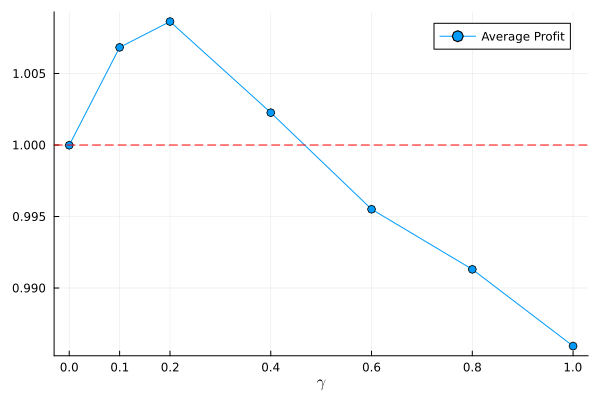

"/Users/zhangxun/Codes/Data/Product_Line_Design/Model_Mis_Wang_Qi_Shen_N=3_N_x=8_N_u=10_N_nonzero=20_dr=2.0_seed=2_Same_Util_Para/RPLD_vs_ETOPLD_S=200_lambda=0.01.pdf"

In [ ]:
S_train = 100
lambda = 0.01
output_results(S_train,lambda,data_dir,instances,true)

### Check Results

In [ ]:
# lambda = lambda_all[1]
# S_train = 50

# Input_Data = load(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

# gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
# gamma_list = gamma_list
# # println("Gamma list: ", gamma_list)

# obj_True, obj_ETO, obj_RO = obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("S=$(S_train),lambda=$(lambda),obj True:",round.(mean(obj_True),digits=4))
# println("S=$(S_train),lambda=$(lambda),obj ETO:",round.(mean(obj_ETO),digits=4))
# println("S=$(S_train),lambda=$(lambda),obj RO:",round.(mean(obj_RO,dims=1),digits=4))
# println()
# profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("S=$(S_train),lambda=$(lambda),profit True:",round.(mean(profit_True),digits=4))
# println("S=$(S_train),lambda=$(lambda),profit ETO:",round.(mean(profit_ETO),digits=4))
# println("S=$(S_train),lambda=$(lambda),profit RO:",round.(mean(profit_RO,dims=1),digits=4))


In [ ]:
# ins = 2
# nu_true = Input_Data["ins=$ins"]["nu_true"];
# nu_hat = Input_Data["ins=$ins"]["nu_hat"];
# r_params = Input_Data["ins=$ins"]["r_params"];

In [ ]:
# function obtain_probs(Design, nu_true)
#     utilties = Design * nu_true[2:end] .+ nu_true[1]
#     exp_utilities = exp.(utilties)
#     prob = exp_utilities ./ (sum(exp_utilities)+1)
#     return utilties,exp_utilities,prob
# end

In [ ]:
# price_coefs = round.(r_params.r,digits=4)
# println("price coef:",price_coefs)

- True Results

In [ ]:
# Design_True = RST_True_All["ins=$ins"]["X"][1,:,:];

In [ ]:
# price_True = Design_True * price_coefs;
# println("price True = ", round.(price_True,digits=4))

In [ ]:
# utilties_True,exp_utilities_True,prob_True = obtain_probs(Design_True, nu_true);
# println("probs True = ",round.(prob_True,digits=4))
# println("Rev True = ",round.(price_True' * prob_True,digits=4))

- ETO Results

In [ ]:
# Design_ETO = RST_ETO_All["ins=$ins"]["X"][1,:,:];

In [ ]:
# price_ETO = Design_ETO * price_coefs;
# println("price ETO = ", round.(price_ETO,digits=4))

In [ ]:
# utilties_ETO,exp_utilities_ETO,prob_ETO = obtain_probs(Design_ETO, nu_true);
# println("probs ETO = ",round.(prob_ETO,digits=4))
# println("Rev ETO = ",price_ETO' * prob_ETO)